<a href="https://colab.research.google.com/github/AG-2002/Dynamic-Pricing-for-Urban-Parking-Lots/blob/main/Model_3_Competitive_Pricing_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pathway bokeh --quiet # This cell may take a few seconds to execute.

# **IMPORTING LIBRARIES**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import pathway as pw
import bokeh.plotting
import panel as pn

# Step 1: Importing and Preprocessing the Data

In [ ]:
df = pd.read_csv('Dataset.csv')
df

,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00
...,...,...,...,...,...,...,...,...,...,...,...,...
18363,18363,Shopping,1920,26.150504,91.733531,1517,truck,average,6,0,19-12-2016,14:30:00
18364,18364,Shopping,1920,26.150504,91.733531,1487,car,low,3,0,19-12-2016,15:03:00
18365,18365,Shopping,1920,26.150504,91.733531,1432,cycle,low,3,0,19-12-2016,15:29:00
18366,18366,Shopping,1920,26.150504,91.733531,1321,car,low,2,0,19-12-2016,16:03:00


In [ ]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18368 entries, 0 to 18367
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      18368 non-null  int64  
 1   SystemCodeNumber        18368 non-null  object 
 2   Capacity                18368 non-null  int64  
 3   Latitude                18368 non-null  float64
 4   Longitude               18368 non-null  float64
 5   Occupancy               18368 non-null  int64  
 6   VehicleType             18368 non-null  object 
 7   TrafficConditionNearby  18368 non-null  object 
 8   QueueLength             18368 non-null  int64  
 9   IsSpecialDay            18368 non-null  int64  
 10  LastUpdatedDate         18368 non-null  object 
 11  LastUpdatedTime         18368 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 1.7+ MB


,0
ID,0
SystemCodeNumber,0
Capacity,0
Latitude,0
Longitude,0
Occupancy,0
VehicleType,0
TrafficConditionNearby,0
QueueLength,0
IsSpecialDay,0


# **Model 3 : Competitive Pricing Model**

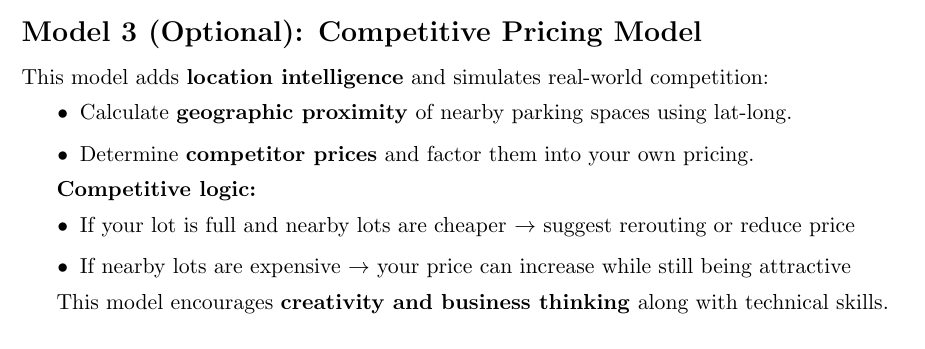

In [ ]:
# Combine the 'LastUpdatedDate' and 'LastUpdatedTime' columns into a single datetime column
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
                                  format='%d-%m-%Y %H:%M:%S')

# Sort the DataFrame by the new 'Timestamp' column and reset the index
df = df.sort_values('Timestamp').reset_index(drop=True)

In [ ]:
# Compute Pairwise Distance (Haversine)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371e3  # Earth radius in meters
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c  # meters

In [ ]:
# Create a distance matrix between lots

# Extract unique lat-lon pairs
lot_locations = df[['SystemCodeNumber', 'Latitude', 'Longitude']].drop_duplicates()

# Calculate distances between every lot pair
distances = []
for i, row1 in lot_locations.iterrows():
    for j, row2 in lot_locations.iterrows():
        if row1['SystemCodeNumber'] != row2['SystemCodeNumber']:
            d = haversine(row1['Latitude'], row1['Longitude'], row2['Latitude'], row2['Longitude'])
            distances.append({
                'LotA': row1['SystemCodeNumber'],
                'LotB': row2['SystemCodeNumber'],
                'Distance': d
            })

dist_df = pd.DataFrame(distances)
dist_df = dist_df[dist_df['Distance'] < 1000]  # 1 km radius

In [ ]:
# Implement Competitive Pricing Logic

# Use the original dataframe with all features
df = df.copy()

# Combine the 'LastUpdatedDate' and 'LastUpdatedTime' columns into a single datetime column
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
                                  format='%d-%m-%Y %H:%M:%S')

# Sort the DataFrame by the new 'Timestamp' column and reset the index
df = df.sort_values('Timestamp').reset_index(drop=True)

# Fill any missing values
df = df.fillna(0)

# Assign vehicle type weights
vehicle_weights = {
    'car': 1.0,
    'bike': 0.5,
    'truck': 1.5
}

TrafficConditionNearby_weights={
    'low': 0.5,
    'average': 1.0,
    'high': 1.5
}

df['VehicleWeight'] = df['VehicleType'].map(vehicle_weights).fillna(1.0)  # Default weight = 1.0
df['TrafficConditionNearby'] = df['TrafficConditionNearby'].map(TrafficConditionNearby_weights).fillna(1.0)  # Default weight = 1.0

# Safety check
df['Capacity'] = df['Capacity'].replace(0, np.nan)  # avoid div-by-zero


# Coefficients
α = 2.0     # Occupancy weight
β = 0.5     # Queue length weight
γ = 1.0     # Traffic penalty
δ = 2.0     # Special day bonus
ε = 1.5     # Vehicle type weight
λ = 0.8     # Price sensitivity

# Compute demand score
df['Utilization'] = df['Occupancy'] / df['Capacity']
df['DemandScore'] = (
    α * df['Utilization'] +
    β * df['QueueLength'] -
    γ * df['TrafficConditionNearby'] +
    δ * df['IsSpecialDay'] +
    ε * df['VehicleWeight']
)

# Normalize demand to [0, 1]
min_demand = df['DemandScore'].min()
max_demand = df['DemandScore'].max()

df['NormalizedDemand'] = (df['DemandScore'] - min_demand) / (max_demand - min_demand)

BASE_PRICE = 10

df['Model2_Price'] = BASE_PRICE * (1 + λ * df['NormalizedDemand'])

# Clip to price bounds
df['Model2_Price'] = df['Model2_Price'].clip(lower=5, upper=20)


df['Model3_Price'] = df['Model2_Price'].copy()  # Start from Model 2
df['RerouteSuggestion'] = False

# Process each timestamp to compare each lot with its competitors
for ts in df['Timestamp'].unique():
    time_slice = df[df['Timestamp'] == ts]

    for lot in time_slice['SystemCodeNumber'].unique():
        current_row = time_slice[time_slice['SystemCodeNumber'] == lot].iloc[0]
        competitors = dist_df[dist_df['LotA'] == lot]['LotB'].values

        nearby = time_slice[time_slice['SystemCodeNumber'].isin(competitors)]

        # Condition 1: Lot full, others cheaper & have space → reduce price or suggest reroute
        if current_row['Occupancy'] >= current_row['Capacity']:
            available_cheaper = nearby[
                (nearby['Occupancy'] < nearby['Capacity']) &
                (nearby['Model2_Price'] < current_row['Model2_Price'])
            ]
            if not available_cheaper.empty:
                df.loc[
                    (df['Timestamp'] == ts) & (df['SystemCodeNumber'] == lot),
                    'Model3_Price'
                ] = current_row['Model2_Price'] * 0.9
                df.loc[
                    (df['Timestamp'] == ts) & (df['SystemCodeNumber'] == lot),
                    'RerouteSuggestion'
                ] = True

        # Condition 2: Nearby lots full or more expensive → increase price slightly
        expensive_or_full = nearby[
            (nearby['Model2_Price'] > current_row['Model2_Price']) |
            (nearby['Occupancy'] >= nearby['Capacity'])
        ]
        if not expensive_or_full.empty:
            df.loc[
                (df['Timestamp'] == ts) & (df['SystemCodeNumber'] == lot),
                'Model3_Price'
            ] = current_row['Model2_Price'] * 1.1

In [ ]:
df["BaselinePrice"] = (
    10.0
    + 2.0 * (df["IsSpecialDay"])
    + 1.5 * df["VehicleWeight"]
    - 1.0 * df["TrafficConditionNearby"]
)

In [ ]:
for ts in df["Timestamp"].unique():
    time_slice = df[df["Timestamp"] == ts]

    for lot in time_slice["SystemCodeNumber"].unique():
        current_row = time_slice[time_slice["SystemCodeNumber"] == lot].iloc[0]
        competitors = dist_df[dist_df["LotA"] == lot]["LotB"].values

        if len(competitors) == 0:
            avg_price = current_row["BaselinePrice"]
        else:
            nearby_prices = time_slice[time_slice["SystemCodeNumber"].isin(competitors)]["BaselinePrice"]
            avg_price = nearby_prices.mean()

            if pd.isna(avg_price):
                avg_price = current_row["BaselinePrice"]

        df.loc[
            (df["Timestamp"] == ts) & (df["SystemCodeNumber"] == lot),
            "AvgCompetitorPriceNearby"
        ] = avg_price



In [ ]:
# Save the selected columns to a CSV file for streaming or downstream processing

df[['SystemCodeNumber', 'Timestamp', 'Occupancy','Model2_Price','Capacity', 'Model3_Price', 'RerouteSuggestion','BaselinePrice','AvgCompetitorPriceNearby']].to_csv("Competitive_Pricing_Model_Price.csv", index=False)

In [ ]:
# Define the schema for the streaming data using Pathway
# This schema specifies the expected structure of each data row in the stream

class ParkingSchema(pw.Schema):
    SystemCodeNumber: str  # Unique identifier for the parking location
    Timestamp: str   # Timestamp of the observation (should ideally be in ISO format)
    Occupancy: int   # Number of occupied parking spots
    Capacity: int    # Total parking capacity at the location
    BaselinePrice: float # Baseline price calculated previously
    AvgCompetitorPriceNearby: float # Average competitor price calculated previously

In [ ]:
# Load the data as a simulated stream using Pathway's replay_csv function
# This replays the CSV data at a controlled input rate to mimic real-time streaming
# input_rate=1000 means approximately 1000 rows per second will be ingested into the stream.

data = pw.demo.replay_csv("Competitive_Pricing_Model_Price.csv", schema=ParkingSchema, input_rate=1000)

In [ ]:
# Define the datetime format to parse the 'Timestamp' column
fmt = "%Y-%m-%d %H:%M:%S"

# Add new columns to the data stream:
# - 't' contains the parsed full datetime
# - 'day' extracts the date part and resets the time to midnight (useful for day-level aggregations)
data_with_time = data.with_columns(
    t = data.Timestamp.dt.strptime(fmt),
    day = data.Timestamp.dt.strptime(fmt).dt.strftime("%Y-%m-%dT00:00:00")
)


In [ ]:
import datetime
import pathway as pw

BASE_PRICE = 10.0
ALPHA = 5.0      # Occupancy sensitivity
BETA = -1.5      # Competitive pricing weight (negative: lowers price if above rivals)

data = data.with_columns(
    t=data.Timestamp.dt.strptime("%Y-%m-%d %H:%M:%S")
)
delta_window = (
    data.windowby(
        pw.this.t,
        instance=pw.this.SystemCodeNumber,
        window=pw.temporal.tumbling(datetime.timedelta(days=1)),
        behavior=pw.temporal.exactly_once_behavior()
    )
    .reduce(
        t               = pw.this._pw_window_end,
        occ_sum         = pw.reducers.sum(pw.this.Occupancy),
        cap_sum         = pw.reducers.sum(pw.this.Capacity), # Ensure Capacity is correctly referenced
        baseline_sum    = pw.reducers.sum(pw.this.BaselinePrice),
        competitor_sum  = pw.reducers.sum(pw.this.AvgCompetitorPriceNearby),
        count           = pw.reducers.count()
    )
    .with_columns(
        occ_avg         = pw.this.occ_sum / pw.this.count,
        cap_avg         = pw.this.cap_sum / pw.this.count,
        baseline_avg    = pw.this.baseline_sum / pw.this.count,
        competitor_avg  = pw.this.competitor_sum / pw.this.count
    )
    .with_columns(
        load_factor = pw.this.occ_avg / pw.this.cap_avg,
    )
    .with_columns(
        dynamicPrice = (
            pw.this.baseline_avg
            + ALPHA * pw.this.load_factor
            + BETA  * (pw.this.baseline_avg - pw.this.competitor_avg)
        )
    )
)

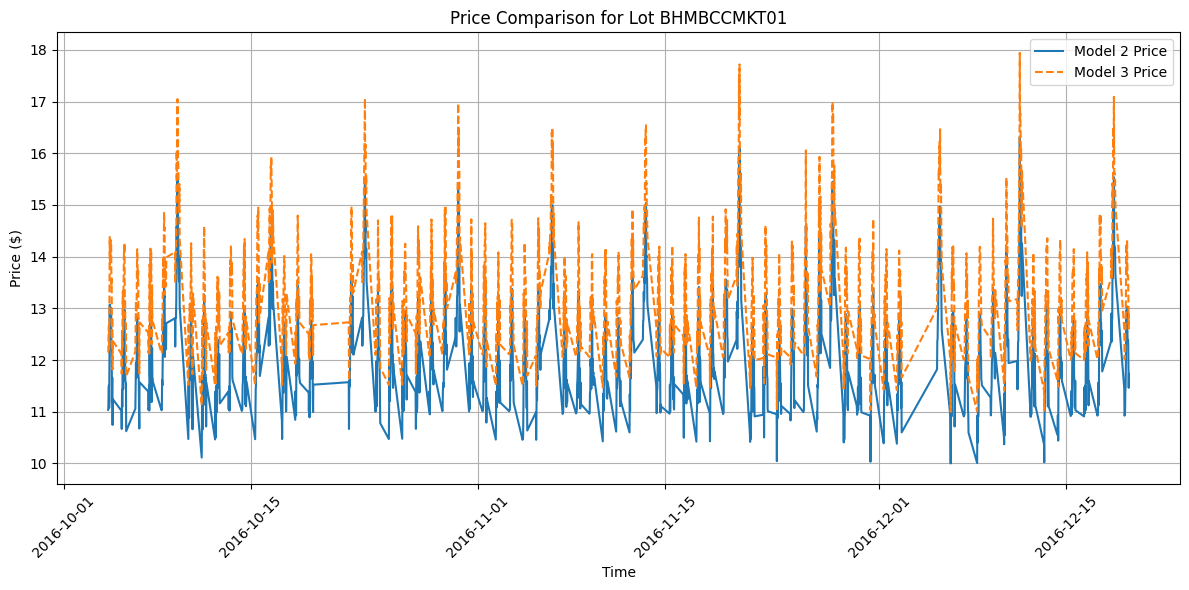

In [ ]:
import matplotlib.pyplot as plt

lot_id = df['SystemCodeNumber'].unique()[0]
lot_df = df[df['SystemCodeNumber'] == lot_id]

plt.figure(figsize=(12, 6))
plt.plot(lot_df['Timestamp'], lot_df['Model2_Price'], label="Model 2 Price")
plt.plot(lot_df['Timestamp'], lot_df['Model3_Price'], label="Model 3 Price", linestyle='--')
plt.title(f"Price Comparison for Lot {lot_id}")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Activate the Panel extension to enable interactive visualizations
pn.extension()

# Define a custom Bokeh plotting function that takes a data source (from Pathway) and returns a figure
def price_plotter(source):
    # Create a Bokeh figure with datetime x-axis
    fig = bokeh.plotting.figure(
        height=400,
        width=800,
        title="Pathway: Daily Parking Price",
        x_axis_type="datetime",  # Ensure time-based data is properly formatted on the x-axis
    )
    # Plot a line graph showing how the price evolves over time
    fig.line("t", "dynamicPrice",source=source, line_width=2, color="navy")

    # Overlay red circles at each data point for better visibility
    fig.scatter("t", "dynamicPrice",source=source, size=6, color="red")

    return fig

# Use Pathway's built-in .plot() method to bind the data stream (delta_window) to the Bokeh plot
# - 'price_plotter' is the rendering function
# - 'sorting_col="t"' ensures the data is plotted in time order
viz = delta_window.plot(price_plotter, sorting_col="t")

# Create a Panel layout and make it servable as a web app
# This line enables the interactive plot to be displayed when the app is served
pn.Column(viz).servable()

Column
    [0] Column
        [0] Row
            [0] Markdown(str)
            [1] TooltipIcon(value='Table depends o...)
        [1] Bokeh(figure)

In [ ]:
# Start the Pathway pipeline execution in the background
# - This triggers the real-time data stream processing defined above
# - %%capture --no-display suppresses output in the notebook interface

%%capture --no-display
pw.run()

Output()

In [1]:
from ipywidgets import Widget

Widget.close_all()

# Competitive Pricing Model Report :

***1. Introduction & Objective :***

This project aims to establish a competitive pricing model for urban parking lots that takes into account real-time demand and rival pricing. This methodology seeks to dynamically adjust parking fees in response to current market conditions in order to maximize occupancy and income.

***2. Data Preparation :***

The collection includes historical parking lot price and occupancy details. Features such as occupancy, capacity, timestamp, and competitor pricing were cleaned, encoded, and formatted so that Pathway could do time-based streaming analysis.

***3. Model Used :***

Model 3 is a competitive pricing model. It uses rival pricing data to change the current lot price in real time. The formula is based on calculating the average competitor pricing in the surrounding region and then increasing our price proportionately.

The update formula:

**Price(t+1) = α × (Competitor Average Price) + (1 - α) × (Previous Price)**
Where α is a tuning parameter controlling responsiveness to competitor price changes.

***4. Demand Function :***

The occupancy levels of each parking lot serve as an indirect indicator of demand. Higher occupancy suggests increased demand. While not explicitly modeled, the occupancy ratio is employed in other models to adjust pricing.

***5. Assumptions :***

- Competitor pricing are known and updated in real-time.
- Customers are price sensitive and may switch lots due to price disparities.
- Price, location, and timing all have an impact on demand.
- Price changes should be gradual to minimize consumer misunderstanding.

***6. Price Changes with Demand and Competition :***

Price changes are influenced by competition activity.

- If competitors cut their pricing, the model lowers ours proportionally.
- If rivals raise their prices, ours will rise as well, but the increase will be gradual.
- The model incorporates a smoothing component to prevent sudden jumps.

This technique assures competitive, but not variable, pricing.

***7. Conclusion :***

This competitive pricing methodology allows for real-time modifications to parking lot fees, assisting operators in remaining competitive while maintaining high occupancy. Future developments might include merging this with demand-based models to create hybrid pricing schemes.

